# Purpose

- Test out math and basic implementations for SBL

# Data

Regardless of which approach we are testing, we will want synthetic data to test it on. Nameley we want 

$\mathbf{z}_{j}^{\ell} = (z_{j}^{1,\ell}, \ldots, z_{j}^{K,\ell})^{\top}$ \
\
$\mathbf{z}_{j}^{\ell} \sim \mathcal{CN}(0, \boldsymbol{\Gamma}_{j})$

for cases where $\boldsymbol{\Gamma}_{j}$ is low-rank and full-rank

For now we'll just load data previously generated with `experiments/simulate/simulate_simply.py`. If we need to customize the generated data later we can build off the code found there. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.random as jr
import jax.numpy as jnp

from cohlib.utils import pickle_open
import cohlib.confs.utils as conf

In [70]:
import matplotlib.pyplot as plt

In [3]:
data_path = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_rank1/window1000/gseed0/K3/L25/lseed0/latent_sim.pkl"
data_load = pickle_open(data_path)
data_load.keys()

dict_keys(['lcfg', 'zs_nz', 'nz', 'freqs'])

In [4]:
lcfg = conf.omega(data_load['lcfg'])
lrccn_true = conf.create_lrccn_basic_rank1(lcfg)

In [5]:
lrccn_true.get_gamma()

Array([[[ 999.99994  +0.j     , -584.52826-811.3733j ,
         -494.32022+869.27985j],
        [-584.52826+811.37335j, 1000.       +0.j     ,
         -416.3664 -909.1969j ],
        [-494.32022-869.2799j , -416.3664 +909.1969j ,
         1000.       +0.j     ]]], dtype=complex64)

We can either used the saved zs or sample from the ccn object

In [6]:
# load previous
zs_nz = data_load['zs_nz']
zs_nz

Array([[[ 24.663574  -23.353806j ,  -8.790439  +24.903954j ,
          22.38969    -5.7245426j, -21.87929   +13.264801j ,
          20.046848  -19.144785j ,  19.00042   -20.42281j  ,
          13.458469   +4.917706j ,   0.8040265 +26.533617j ,
          -9.540282  -45.654533j ,   0.57908654 +1.0375762j,
          -2.8637877  -7.1300316j,  14.736345  -10.20982j  ,
          53.646378  +24.527653j ,   2.0831683 -18.137947j ,
          15.809136   -4.5414224j,   8.386047  -31.615107j ,
           0.81120723 -5.9142723j,  21.538671   -5.1345263j,
          45.124634  +13.239729j ,  28.76789   +15.464066j ,
          -5.098655   +0.3173582j, -14.28832   -24.856436j ,
           4.9900517 -24.736385j ,  16.36705   -10.786745j ,
          -8.868884  +38.479794j ],
        [  4.532099  +33.662327j , -15.068144  -21.689392j ,
          -8.442667  +21.512554j ,   2.0263586 -25.505922j ,
           3.8156185 +27.456146j ,   5.464241  +27.354145j ,
         -11.856952   +8.045304j , -21.998646  -1

In [7]:
# new sample
rk = jr.key(7)
sample = lrccn_true.sample_nz(rk, 1000)
sample.shape


(1, 3, 1000)

In [8]:
est = jnp.einsum('jkl,jil->jkil', sample, sample.conj()).mean(-1).squeeze()
print(est)
print(lrccn_true.get_gamma())

[[1001.0352 -1.4062957e-07j -585.1334 -8.1221332e+02j
  -494.832  +8.7017981e+02j]
 [-585.1334 +8.1221332e+02j 1001.0352 +2.3366314e-07j
  -416.79742-9.1013818e+02j]
 [-494.832  -8.7017987e+02j -416.79742+9.1013818e+02j
  1001.0353 +3.1689677e-07j]]
[[[ 999.99994  +0.j      -584.52826-811.3733j  -494.32022+869.27985j]
  [-584.52826+811.37335j 1000.       +0.j      -416.3664 -909.1969j ]
  [-494.32022-869.2799j  -416.3664 +909.1969j  1000.       +0.j     ]]]


So, task now is to come up with and test some methods for doing the low-rank estimation
- full Bayesian
- ARD
- brute force with Jax

The faster we can get something working the better off we are. 

In [11]:
Z = zs_nz.squeeze()
Z.shape

(3, 25)

In [51]:
import jax, jax.numpy as jnp
from jax.scipy.linalg import cholesky, solve_triangular

def run_sbl(Z, R_max, max_iter=200, tol=1e-6,
            a0=1e-6, b0=1e-6, c0=1e-6, d0=1e-6, alpha_max=1e8):
    K, N = Z.shape
    # 1 Initialise
    C = (Z @ Z.conj().T) / N
    eigvals, eigvecs = jnp.linalg.eigh(C)
    idx = jnp.argsort(eigvals)[::-1][:R_max]
    L = eigvecs[:, idx] * jnp.sqrt(eigvals[idx])
    sig2 = jnp.mean(eigvals[R_max:])
    alpha = jnp.ones(R_max)

    for it in range(max_iter):
        if it % 10 == 0:
            print(it)
        # E-step
        A = L.conj().T @ L / sig2 + jnp.eye(R_max)
        Sigma_x = jnp.linalg.inv(A)
        M = Sigma_x @ (L.conj().T @ Z) / sig2         # R×N
        Sxz = M @ Z.conj().T                          # R×K
        Sxx = M @ M.conj().T + N * Sigma_x            # R×R
        # M-step
        L_new = (Sxz.conj().T) @ jnp.linalg.inv(Sxx + jnp.diag(alpha))
        alpha_new = (K + 2*a0) / (jnp.sum(jnp.abs(L_new)**2,0) + 2*b0)
        resid = Z - L_new @ M
        sig2_new = (jnp.sum(jnp.abs(resid)**2) + 2*d0) / (K*N + 2*c0)
        # Convergence test
        if jnp.max(jnp.abs(L_new-L)) < tol: break
        L, alpha, sig2 = L_new, jnp.minimum(alpha_new, alpha_max), sig2_new
        # Prune
        keep = alpha < alpha_max
        L, alpha = L[:, keep], alpha[keep]
    Gamma_hat = L @ L.conj().T + sig2 * jnp.eye(K)
    return Gamma_hat, L, alpha, sig2


In [52]:
R_max = 2

K, N = Z.shape
# 1 Initialise
C = (Z @ Z.conj().T) / N
eigvals, eigvecs = jnp.linalg.eigh(C)
idx = jnp.argsort(eigvals)[::-1][:R_max]
L = eigvecs[:, idx] * jnp.sqrt(eigvals[idx])
sig2 = jnp.mean(eigvals[R_max:])
alpha = jnp.ones(R_max)

In [53]:
idx

Array([2, 1], dtype=int32)

In [54]:
G, Lest, alpha, sig2 = run_sbl(Z, 2, max_iter=3)

0


In [34]:
jnp.linalg.eigh(Lest @ Lest.conj().T)

EighResult(eigenvalues=Array([-4.1571358e-05,  1.9415922e-04,  1.3046693e+03], dtype=float32), eigenvectors=Array([[ 0.1768078 -0.j        ,  0.7971232 +0.j        ,
         0.57735026+0.j        ],
       [-0.29803276+0.5234681j ,  0.3105383 -0.45540133j,
        -0.33747762+0.46844664j],
       [ 0.4392443 +0.6426204j ,  0.10928239+0.22096907j,
        -0.28539595-0.501879j  ]], dtype=complex64))

Let's start with pymc and build the following model:

$\mathbf{z}_{j}^{\ell} = \mathbf{B} {\mathbf{z}_{j}^*}^{\ell}$ \
${\mathbf{z}_{j}^*}^{\ell} \sim \mathcal{CN}(0, \mathbf{D}_{j})$ \
$\mathbf{D}_{j} = \text{diag}(d^{1}_{j}, \ldots, d^{K}_{j})$ \
$d_{j}^{k} \sim  \text{Gamma}(a,b)$


In [81]:
import numpy as np

def simulate_cscn_data(K=3, n_samples=500, seed=0):
    rng = np.random.default_rng(seed)

    # Random low-rank complex A
    r = K
    A = rng.normal(0, 1, size=(K, r)) + 1j * rng.normal(0, 1, size=(K, r))

    # Hermitian PSD
    Gamma = A @ A.conj().T + 0.5 * np.eye(K)

    from scipy.linalg import cholesky
    L = cholesky(Gamma, lower=True)

    # Standard complex normals
    z_std_normal = rng.normal(size=(n_samples, K)) + 1j * rng.normal(size=(n_samples, K))

    # Correct sampling
    z_samples = (L @ z_std_normal.T) / np.sqrt(2)  # shape (K, n_samples)
    z_samples = z_samples.T  # shape (n_samples, K)

    return z_samples, Gamma

z_obs, Gamma_true = simulate_cscn_data(K=20, n_samples=100)


In [82]:
jnp.linalg.eigh(Gamma_true)

EighResult(eigenvalues=Array([  0.62651384,   0.96259266,   1.8898621 ,   3.525062  ,
         4.048359  ,   6.221047  ,  10.093374  ,  12.442522  ,
        19.665043  ,  23.02493   ,  28.067673  ,  35.868702  ,
        47.232346  ,  51.388912  ,  58.887005  ,  66.93713   ,
        79.51224   ,  91.24917   , 128.44246   , 140.9509    ],      dtype=float32), eigenvectors=Array([[-2.66921073e-02+0.j        ,  2.26137459e-01+0.j        ,
         1.29458919e-01+0.j        , -8.87223557e-02+0.j        ,
        -1.26783758e-01+0.j        ,  3.43096256e-01+0.j        ,
        -3.03163052e-01+0.j        ,  1.08887769e-01+0.j        ,
        -1.88241005e-01+0.j        ,  3.42450440e-01+0.j        ,
        -1.52449757e-01+0.j        ,  2.53528357e-01+0.j        ,
        -3.96540940e-01+0.j        ,  2.02594295e-01+0.j        ,
        -8.10941383e-02+0.j        ,  1.86664641e-01+0.j        ,
        -2.51200736e-01+0.j        ,  3.10505748e-01+0.j        ,
         1.57228574e-01+0.j      

In [74]:
G, Lest, alpha, sig2 = run_sbl(z_obs.T, 3, max_iter=500)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270


In [75]:
Lest.shape

(5, 3)

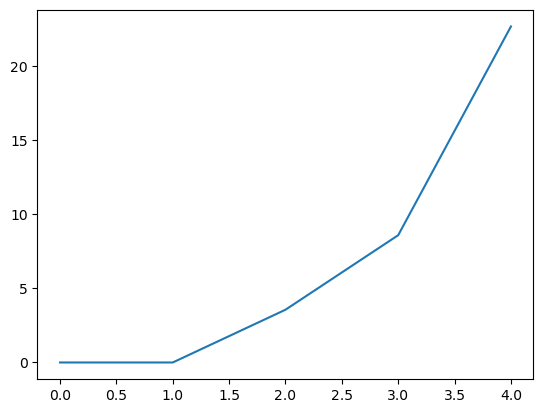

In [76]:
eigvals, eigvecs = jnp.linalg.eigh(Lest @ Lest.conj().T)
plt.plot(eigvals)

In [77]:
jnp.linalg.eigh(G)

EighResult(eigenvalues=Array([ 0.38396686,  0.3839689 ,  3.9471214 ,  8.981218  , 23.079084  ],      dtype=float32), eigenvectors=Array([[-0.93073726+0.j        , -0.16350627+0.j        ,
         0.1547695 +0.j        ,  0.16619436+0.j        ,
        -0.2354137 -0.j        ],
       [ 0.06022283+0.1947903j ,  0.3588519 -0.30901393j,
         0.55879956+0.2488017j ,  0.03113401+0.5906017j ,
        -0.0979839 +0.02501414j],
       [-0.11312798-0.11549934j,  0.496231  +0.19599399j,
        -0.4489226 -0.13134459j,  0.40654862+0.3059244j ,
         0.09448092+0.45013556j],
       [-0.20841122-0.11147641j,  0.42215884+0.00278415j,
         0.31809717-0.51524174j, -0.36689094-0.18065798j,
         0.48088548-0.02747505j],
       [-0.08385134+0.05591674j, -0.4792946 +0.23747341j,
         0.02606874+0.12555657j,  0.02686497+0.44244787j,
         0.70051444+0.00888861j]], dtype=complex64))

In [78]:
jnp.linalg.eigh(Gamma_true)

EighResult(eigenvalues=Array([ 0.6142048,  1.4245344,  4.862659 , 10.52285  , 27.415787 ],      dtype=float32), eigenvectors=Array([[ 0.8202613 +0.j        , -0.44908533+0.j        ,
        -0.17566153+0.j        ,  0.17789178+0.j        ,
        -0.25098053+0.j        ],
       [-0.21356365-0.31786498j, -0.15527584-0.25715175j,
        -0.54287803-0.13481124j, -0.11944247+0.6478737j ,
        -0.124834  -0.02516796j],
       [ 0.15382296-0.16787662j,  0.2326188 -0.38961703j,
         0.4134227 -0.20632097j,  0.42951807+0.29109025j,
         0.10157977+0.49921748j],
       [ 0.21444629-0.11835641j,  0.06707137-0.47586873j,
        -0.08227276+0.65037256j, -0.24479258-0.05035871j,
         0.46492365-0.02622258j],
       [ 0.21186538+0.15426369j,  0.0058415 +0.52075696j,
        -0.00342249-0.11401812j, -0.02591354+0.4494409j ,
         0.66599995-0.02927486j]], dtype=complex64))

In [80]:
alpha

Array([0.2203118, 0.5815813, 1.4032508], dtype=float32)

In [ ]:
# try without noise
# add noise to observations

In [17]:
# First, let's get up and running with a complex-valued distribution

In [18]:
import pymc as pm
import aesara.tensor as at
import numpy as np

class ComplexMVN(pm.distributions.Distribution):
    """
    Circular Complex Multivariate Normal:
    z ~ CN(0, Γ) modeled as real-valued MVN over [Re(z); Im(z)].
    
    Assumes:
    - zero mean
    - circular symmetry
    """

    def __init__(self, cov, **kwargs):
        """
        Parameters
        ----------
        cov : tensor
            Complex covariance matrix Γ (K x K), Hermitian and PSD
        """
        self.K = cov.shape[-1]

        # Build block covariance matrix
        Re_Gamma = at.real(cov)
        Im_Gamma = at.imag(cov)

        # Circular assumption: real and imaginary parts independent, same variance
        top = at.concatenate([Re_Gamma, -Im_Gamma], axis=-1)
        bottom = at.concatenate([Im_Gamma, Re_Gamma], axis=-1)
        block_cov = 0.5 * at.concatenate([top, bottom], axis=0)

        # Register internal real-valued MVN
        super().__init__(**kwargs)
        self._mvn = pm.MvNormal.dist(mu=at.zeros(2 * self.K), cov=block_cov, **kwargs)

    def logp(self, value):
        # Convert complex-valued obs to stacked real vector
        value_real = at.concatenate([at.real(value), at.imag(value)], axis=-1)
        return self._mvn.logp(value_real)

    def random(self, point=None, size=None):
        samples_real = self._mvn.random(point=point, size=size)
        re = samples_real[..., :self.K]
        im = samples_real[..., self.K:]
        return re + 1j * im

AttributeError: module 'numpy.__config__' has no attribute 'get_info'

okie dokie... lets see if we can get a basic tutorial example from pymc to run at all

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Matplotlib is building the font cache; this may take a moment.


In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

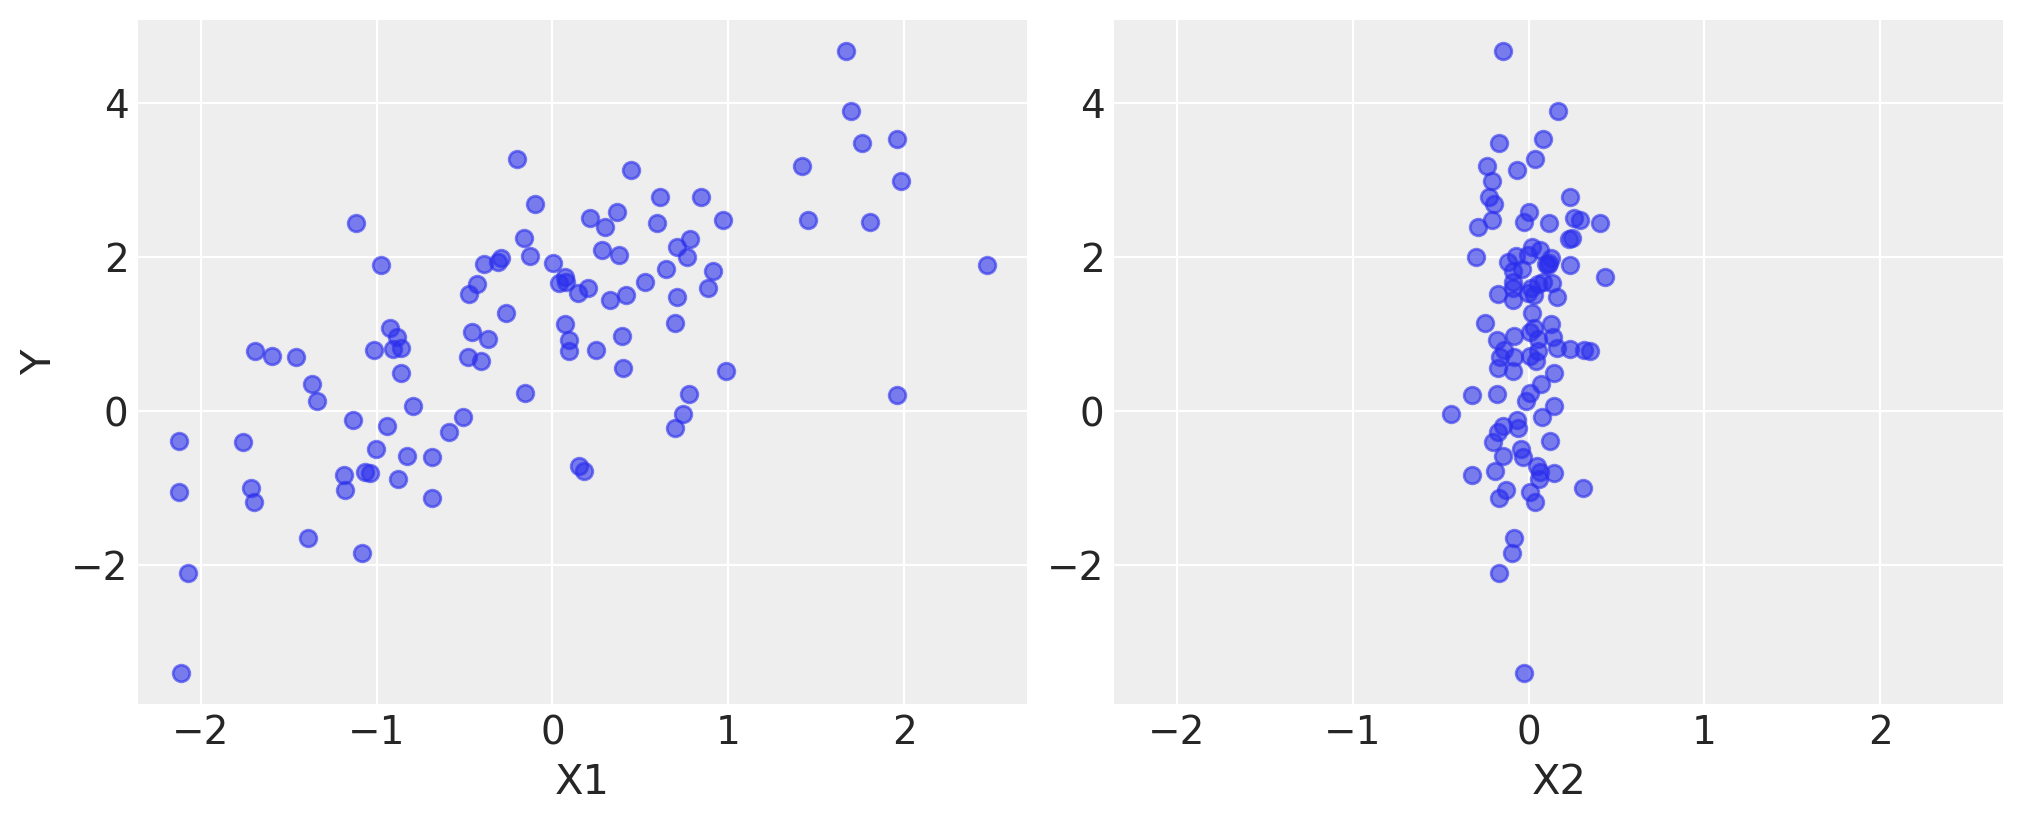

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [5]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.21.1


In [27]:
import pymc as pm
import pytensor.tensor as pt
import numpy as np
 
def ComplexMVN(name, cov, observed=None):
    """
    Factory for circular complex MVN likelihood.
    Accepts real symmetric cov matrix Γ (K x K) and complex observations (L, K).
    Internally converts observations to real.
    """
    K = cov.shape[-1]

    # Real and imag parts of Gamma (Im = 0 under circular symmetry)
    Re_Gamma = cov
    Im_Gamma = pt.zeros_like(cov)

    top = pt.concatenate([Re_Gamma, -Im_Gamma], axis=-1)
    bottom = pt.concatenate([Im_Gamma, Re_Gamma], axis=-1)
    block_cov = 0.5 * pt.concatenate([top, bottom], axis=0)

    if observed is not None:
        # Convert complex obs to stacked real array: shape (L, 2K)
        obs_real = np.concatenate([np.real(observed), np.imag(observed)], axis=-1)
        return pm.MvNormal(name, mu=pt.zeros(2 * K), cov=block_cov, observed=obs_real)
    else:
        return pm.MvNormal(name, mu=pt.zeros(2 * K), cov=block_cov, shape=(2 * K,))

In [28]:
K = 3
with pm.Model() as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", eta=2.0, n=K, sd_dist=pm.HalfNormal.dist(1.0), compute_corr=True
    )
    Gamma_real = chol @ chol.T

    # Complex-valued observations
    z_obs = np.random.randn(100, K) + 1j * np.random.randn(100, K)

    # ComplexMVN wrapper safely converts z_obs to real
    z = ComplexMVN("z", cov=Gamma_real, observed=z_obs)

    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [chol]


/projectnb/stephenlab/jtauber/.conda/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/projectnb/stephenlab/jtauber/.conda/envs/pymc_env/lib/python3.13/site-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/projectnb/stephenlab/jtauber/.conda/envs/pymc_env/lib/python3.13/site-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/projectnb/stephenlab/jtauber/.conda/envs/pymc_env/lib/python3.13/site-packages/pytensor/tensor/subtensor.py:2585: RuntimeWarning: invalid value encountered in add
  np.add.at(x, idx, y)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [30]:
trace.posterior

<xarray.Dataset> Size: 296kB
Dimensions:          (chain: 2, draw: 1000, chol_dim_0: 6, chol_corr_dim_0: 3,
                      chol_corr_dim_1: 3, chol_stds_dim_0: 3)
Coordinates:
  * chain            (chain) int64 16B 0 1
  * draw             (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * chol_dim_0       (chol_dim_0) int64 48B 0 1 2 3 4 5
  * chol_corr_dim_0  (chol_corr_dim_0) int64 24B 0 1 2
  * chol_corr_dim_1  (chol_corr_dim_1) int64 24B 0 1 2
  * chol_stds_dim_0  (chol_stds_dim_0) int64 24B 0 1 2
Data variables:
    chol             (chain, draw, chol_dim_0) float64 96kB 1.411 ... 1.564
    chol_corr        (chain, draw, chol_corr_dim_0, chol_corr_dim_1) float64 144kB ...
    chol_stds        (chain, draw, chol_stds_dim_0) float64 48kB 1.411 ... 1.572
Attributes:
    created_at:                 2025-03-31T20:08:56.749417+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.21.1
    sampling_time:              8.221095085144043
    tuning_steps:               1000

In [34]:
import arviz as az
import numpy as np

# We'll use ArviZ to stack the samples across chains
packed_chol_samples = trace.posterior["chol"].stack(sample=("chain", "draw")).values  # shape: (n_samples, packed_len)


In [46]:
print(packed_chol_samples.shape)

(6, 2000)


In [36]:
from pymc import expand_packed_triangular

In [55]:
packed_chol_samples = np.array(
    trace.posterior["chol"].stack(sample=("chain", "draw"))
).T

In [56]:
print(type(packed_chol_samples))        # should be <class 'numpy.ndarray'>
print(packed_chol_samples.shape)        # should be (n_samples, packed_dim)
print(packed_chol_samples[0].shape)     # should be (6,) if K=3

<class 'numpy.ndarray'>
(2000, 6)
(6,)


In [59]:
L

array(AdvancedSetSubtensor.0, dtype=object)

In [62]:
K = 3  # adjust to match your model
n_samples = packed_chol_samples.shape[0]
cov_matrices = np.zeros((n_samples, K, K))

for i in range(n_samples):
    packed = packed_chol_samples[i]
    print(f"Sample {i} packed shape:", packed.shape)

    L = expand_packed_triangular(K, packed)
    print(f"Sample {i} unpacked L type:", type(L))
    print(f"Sample {i} unpacked L shape (if possible):", getattr(L, "shape", "not available"))

    L = np.asarray(L)
    print("L shape after asarray:", L.shape)

    cov_matrices[i] = L @ L.T
    break  # just try the first one for now

Sample 0 packed shape: (6,)
Sample 0 unpacked L type: <class 'pytensor.tensor.variable.TensorVariable'>
Sample 0 unpacked L shape (if possible): Shape.0
L shape after asarray: ()


ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [65]:
packed_chol_samples = trace.posterior["chol"].stack(sample=("chain", "draw")).transpose("sample", ...).values
print("packed_chol_samples shape:", packed_chol_samples.shape)  # should be (2000, 6) if K = 3
print("packed_chol_samples[0] shape:", packed_chol_samples[0].shape)  # should be (6,)

def unpack_chol_manual(packed, K):
    L = np.zeros((K, K))
    idx = 0
    for row in range(K):
        for col in range(row + 1):
            L[row, col] = packed[idx]
            idx += 1
    return L


packed_chol_samples shape: (2000, 6)
packed_chol_samples[0] shape: (6,)


In [66]:
n_samples = packed_chol_samples.shape[0]
K = 3
cov_matrices = np.zeros((n_samples, K, K))

for i in range(n_samples):
    packed = packed_chol_samples[i]
    L = unpack_chol_manual(packed, K)
    cov_matrices[i] = L @ L.T

In [67]:
cov_matrices

array([[[ 1.98985213, -0.03833398,  0.04175345],
        [-0.03833398,  2.02586022,  0.4319233 ],
        [ 0.04175345,  0.4319233 ,  2.47951636]],

       [[ 1.75164429,  0.00759759,  0.03686524],
        [ 0.00759759,  2.58745673,  0.71940168],
        [ 0.03686524,  0.71940168,  2.72943988]],

       [[ 1.87563294,  0.28433817, -0.04599359],
        [ 0.28433817,  2.09929694,  0.22411578],
        [-0.04599359,  0.22411578,  2.07433862]],

       ...,

       [[ 1.72214324,  0.1566681 , -0.05837165],
        [ 0.1566681 ,  2.32084684,  0.25543064],
        [-0.05837165,  0.25543064,  1.86955959]],

       [[ 2.05035519, -0.1594246 ,  0.11776143],
        [-0.1594246 ,  1.88282598,  0.22826235],
        [ 0.11776143,  0.22826235,  2.54581431]],

       [[ 1.86475479, -0.20464526,  0.05623948],
        [-0.20464526,  2.17583822,  0.22350596],
        [ 0.05623948,  0.22350596,  2.47228267]]], shape=(2000, 3, 3))

In [68]:
import arviz as az

az.summary(trace, var_names=["chol"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chol[0],1.373,0.069,1.246,1.499,0.001,0.001,2569.0,1662.0,1.0
chol[1],-0.001,0.100,-0.178,0.195,0.002,0.002,2937.0,1818.0,1.0
chol[2],1.487,0.078,1.344,1.632,0.002,0.002,2706.0,1259.0,1.0
chol[3],0.025,0.103,-0.165,0.219,0.002,0.002,2599.0,1070.0,1.0
chol[4],0.184,0.102,-0.001,0.373,0.002,0.002,2292.0,1433.0,1.0
chol[5],1.478,0.076,1.320,1.606,0.002,0.002,2545.0,1193.0,1.0


In [69]:
mean_cov = cov_matrices.mean(axis=0)

In [70]:
mean_cov

array([[ 1.89000571e+00, -1.35540291e-03,  3.51985321e-02],
       [-1.35540291e-03,  2.22786627e+00,  2.74903913e-01],
       [ 3.51985321e-02,  2.74903913e-01,  2.24490571e+00]])

In [71]:
import pymc as pm
import pytensor.tensor as pt
import numpy as np

K = 3
z_obs = np.random.randn(100, K) + 1j * np.random.randn(100, K)  # complex data

with pm.Model() as model:
    # --- Real part of Gamma: A (symmetric) ---
    packed_A = pm.LKJCholeskyCov(
        "packed_A", n=K, eta=2.0, sd_dist=pm.HalfNormal.dist(1.0)
    )
    L_A = pm.expand_packed_triangular(K, packed_A)
    A = pt.dot(L_A, L_A.T)  # real symmetric

    # --- Imag part of Gamma: B (skew-symmetric) ---
    # Sample K*(K-1)/2 parameters for lower triangle
    b_idx = [(i, j) for i in range(1, K) for j in range(i)]
    b_vals = pm.Normal("b_vals", mu=0.0, sigma=1.0, shape=len(b_idx))

    B = pt.zeros((K, K))
    for idx, (i, j) in enumerate(b_idx):
        B = pt.set_subtensor(B[i, j], b_vals[idx])
        B = pt.set_subtensor(B[j, i], -b_vals[idx])

    # --- Build real-valued 2Kx2K block covariance matrix ---
    top = pt.concatenate([A, -B], axis=1)
    bottom = pt.concatenate([B, A], axis=1)
    Sigma = 0.5 * pt.concatenate([top, bottom], axis=0)

    # --- Convert observations to real ---
    z_real_obs = np.concatenate([np.real(z_obs), np.imag(z_obs)], axis=1)

    # --- Likelihood ---
    z = pm.MvNormal("z", mu=pt.zeros(2 * K), cov=Sigma, observed=z_real_obs)

    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)

AttributeError: 'tuple' object has no attribute 'ndim'